In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Objective**
1. To modify an existing Skip-gram model and run it with your
own data.


**Task**
1. You will need the sample code on skip-gram from the lab.
2. Your task is to write your own method to replace
“remove_stop_words” to only consider all types of nouns and
verbs when computing the vector space model.
3. Test it with the existing data and then extend the data set by
adding other sentences and verify that the model gives the
”correct” output.
4. Write a method that outputs the nearest word for a given
word. Use this method to output the nearest word for all given
words in your dataset. (Hint: You can use Euclidean distance)


Convert words to vectors using Count Vectorizer

In [ ]:
corpus = ['king is a strong man',
          'queen is a wise woman',
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong',
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']


import os
# Initialize an empty list to store the contents of the articles
articles = []
# Directory containing NBA articles
directory = "/content/drive/MyDrive/Colab Notebooks/TextMining/lab04-res"

# Iterate through each file in the directory
for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    if os.path.isfile(filepath):
        # Read the content of the file and append it to the list
        with open(filepath, 'r') as file:
            articles.append(file.read())

# 先不启用
#corpus = articles


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def remove_stop_words(corpus):
    stop_words = set(stopwords.words('english'))
    results = []

    for text in corpus :
      print(text);
      tokens = word_tokenize(text)
      tagged_words = pos_tag(tokens)
      print("tagged_words:",tagged_words)
      # only consider all types of nouns and verbs
      filtered_words = [word for word, pos in tagged_words if (pos.startswith('N') or pos.startswith('V')) and word.lower() not in stop_words]
      results.append(' '.join(filtered_words))

    return results




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


TFIDF Example

In [ ]:
corpus = remove_stop_words(corpus)
#print(corpus)
print("=====================================")
words = []

for text in corpus :
    for word in text.split(' ') :
        words.append(word)

words = set(words)
print("words:",words)

king is a strong man
tagged_words: [('king', 'NN'), ('is', 'VBZ'), ('a', 'DT'), ('strong', 'JJ'), ('man', 'NN')]
queen is a wise woman
tagged_words: [('queen', 'NN'), ('is', 'VBZ'), ('a', 'DT'), ('wise', 'NN'), ('woman', 'NN')]
boy is a young man
tagged_words: [('boy', 'NN'), ('is', 'VBZ'), ('a', 'DT'), ('young', 'JJ'), ('man', 'NN')]
girl is a young woman
tagged_words: [('girl', 'NN'), ('is', 'VBZ'), ('a', 'DT'), ('young', 'JJ'), ('woman', 'NN')]
prince is a young king
tagged_words: [('prince', 'NN'), ('is', 'VBZ'), ('a', 'DT'), ('young', 'JJ'), ('king', 'NN')]
princess is a young queen
tagged_words: [('princess', 'NN'), ('is', 'VBZ'), ('a', 'DT'), ('young', 'JJ'), ('queen', 'NN')]
man is strong
tagged_words: [('man', 'NN'), ('is', 'VBZ'), ('strong', 'JJ')]
woman is pretty
tagged_words: [('woman', 'NN'), ('is', 'VBZ'), ('pretty', 'JJ')]
prince is a boy will be king
tagged_words: [('prince', 'NN'), ('is', 'VBZ'), ('a', 'DT'), ('boy', 'NN'), ('will', 'MD'), ('be', 'VB'), ('king', 'VBG')

**Extract the words - skipgrams**

In [ ]:
word2int = {}

for i,word in enumerate(words) :
    word2int[word] = i

sentences = []
for sentence in corpus :
    sentences.append(sentence.split())
    #print(sentences)

WINDOW_SIZE = 2

data = []
for sentence in sentences :
    for idx,word in enumerate(sentence) :
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] :
            if neighbor != word :
                data.append([word, neighbor])

In [ ]:
import pandas as pd

for text in corpus :
    print(text)

df = pd.DataFrame(data, columns = ['input', 'label'])
print(df.head(10))
df.shape

king man
queen wise woman
boy man
girl woman
prince king
princess queen
man
woman
prince boy king
princess girl
   input  label
0   king    man
1    man   king
2  queen   wise
3  queen  woman
4   wise  queen
5   wise  woman
6  woman  queen
7  woman   wise
8    boy    man
9    man    boy


(24, 2)

# **Define a Tensor flow model**

In [ ]:
# importing Tensorflow
import tensorflow.compat.v1 as tf # use legacly tensor flow

# disabling eager mode
tf.compat.v1.disable_eager_execution()
import numpy as np

ONE_HOT_DIM = len(words)

# one-hot-encoding
def to_one_hot_encoding(data_point_index) :
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1

    return one_hot_encoding

X = [] # input word
Y = [] # target word

for x, y in zip(df['input'], df['label']) :
    X.append(to_one_hot_encoding(word2int[ x ]))
    Y.append(to_one_hot_encoding(word2int[ y ]))

# numpy array
X_train = np.asarray(X)
Y_train = np.asarray(Y)

# X_train Y_train placeholder
x = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))
#在这段代码中，x 是一个输入占位符，用于接收输入数据，它的形状是 (None, ONE_HOT_DIM)，
# 其中 None 表示可以接收任意数量的输入样本，
# ONE_HOT_DIM 表示每个样本的维度为 ONE_HOT_DIM。
# 这样设计的目的是为了能够处理不同大小的输入数据集。

y_label = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))

# word embedding
EMBEDDING_DIM = 2

# hidden layer
W1 = tf.Variable(tf.random_normal([ONE_HOT_DIM, EMBEDDING_DIM]))
#创建了一个形状为 [ONE_HOT_DIM, EMBEDDING_DIM] 的 TensorFlow 变量（Variable），
#  其中 ONE_HOT_DIM 表示输入特征的维度（即输入的 one-hot 编码向量的维度），
#  EMBEDDING_DIM 表示隐藏层的维度（即隐藏单元的数量）。

# 这个变量 W1 包含了输入层到隐藏层的权重参数，初始值为从正态分布中随机采样的值。
b1 = tf.Variable(tf.random_normal([1])) # bias
#创建了一个形状为 [1] 的 TensorFlow 变量，表示隐藏层的偏置（bias）。
#这个偏置向量 b1 用于在权重矩阵和输入数据相乘后的结果上加上一个常数偏置项。
hidden_layer = tf.add(tf.matmul(x,W1), b1)
#计算了隐藏层的输出。首先，使用 tf.matmul 函数对输入数据 x 和权重矩阵 W1 进行矩阵相乘，得到输入数据在隐藏层的投影。
#然后，使用 tf.add 函数将投影结果和偏置向量 b1 相加，得到隐藏层的未激活输出

# output layer
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, ONE_HOT_DIM]))
b2 = tf.Variable(tf.random_normal([1]))
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, W2), b2))

#W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, ONE_HOT_DIM]))：创建了一个形状为 [EMBEDDING_DIM, ONE_HOT_DIM] 的 TensorFlow 变量（Variable），表示隐藏层到输出层的权重矩阵。
#   其中 EMBEDDING_DIM 是隐藏层的维度，ONE_HOT_DIM 是输出的维度（即标签的数量）。这个权重矩阵 W2 包含了隐藏层到输出层的连接权重，初始值为从正态分布中随机采样的值。

#b2 = tf.Variable(tf.random_normal([1]))：创建了一个形状为 [1] 的 TensorFlow 变量，表示输出层的偏置（bias）。这个偏置向量 b2 用于在隐藏层的输出结果上加上一个常数偏置项。

#tf.matmul(hidden_layer, W2)：使用 tf.matmul 函数对隐藏层的输出 hidden_layer 和权重矩阵 W2 进行矩阵相乘，得到隐藏层输出在输出层的投影。

#tf.add(..., b2)：使用 tf.add 函数将投影结果和偏置向量 b2 相加，得到输出层的未激活输出。

#tf.nn.softmax(...)：使用 softmax 函数对输出层的未激活输出进行激活，将其转换为表示类别概率的概率分布。softmax 函数会对向量中的每个元素进行指数运算，然后将结果归一化为一个概率分布，使得所有元素的和为 1。

#最终，prediction 变量包含了神经网络的输出，它表示输入数据在各个类别上的概率分布。在训练过程中，通过不断调整权重矩阵和偏置向量的值，以最小化损失函数来优化神经网络的性能。


# loss function : cross entropy
loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), axis=[1]))
#定义了损失函数，使用的是交叉熵（cross entropy）损失函数。交叉熵是用于度量两个概率分布之间差异性的一种方法，在分类问题中常用于衡量预测值与真实标签之间的差异。
#具体地，这段代码中使用了 TensorFlow 的函数来计算交叉熵损失，其中 y_label 是真实的标签数据，prediction 是神经网络的输出。
#这个损失函数计算了每个样本的交叉熵，并通过 tf.reduce_mean 函数计算了所有样本的平均交叉熵。

#在 TensorFlow 中，axis=[1] 的作用是指定在哪个轴上进行求和操作。具体来说，对于 tf.reduce_sum 函数，axis=[1] 表示沿着第二个维度（索引从 0 开始）对张量进行求和。

#在这段代码中，y_label * tf.log(prediction) 计算了每个样本的交叉熵，其中 y_label 是真实的标签数据，prediction 是神经网络的输出。然后，tf.reduce_sum 函数将这些交叉熵沿着第二个维度进行求和，即对每个样本的交叉熵进行求和，得到一个包含每个样本损失的一维张量。最后，tf.reduce_mean 函数计算了这个一维张量的平均值，得到整个批次样本的平均交叉熵，作为损失函数的值。

#在 TensorFlow 中，张量的维度从 0 开始索引。对于二维张量（矩阵），第一个维度通常表示行数，第二个维度表示列数。因此，沿着第二个维度进行操作意味着沿着列的方向进行操作。

#在一些文档中，特别是在深度学习的上下文中，第一个维度通常是批次大小（batch size），而第二个维度是特征或神经元的数量。在这种情况下，沿着第二个维度进行操作意味着在每个样本中进行操作，而不是在整个批次中进行操作。

#在上述代码中，axis=[1] 表示对每个样本的损失进行求和，而不是对整个批次的损失进行求和。这样可以得到每个样本的损失，然后再通过 tf.reduce_mean 函数计算这些损失的平均值，得到整个批次的平均损失。

# training operation
train_op = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
#定义了训练操作，使用的是梯度下降优化器。梯度下降是一种常用的优化算法，用于调整神经网络中的参数（权重和偏置），使得损失函数最小化。
#在这段代码中，使用了 TensorFlow 的 GradientDescentOptimizer 类创建了一个梯度下降优化器，学习率为 0.05，然后调用 minimize 方法来最小化损失函数 loss，
#这样 TensorFlow 就会自动计算损失函数对所有可训练参数的梯度，并更新参数以降低损失。

In [ ]:
print("Input")
print(X_train.shape)
print(X_train)
print("Output")
print(X_train.shape)
print(Y_train)

Input
(24, 9)
[[0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Output
(24, 9)
[[0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0.

# **Train the model**

In [ ]:
sess = tf.Session()
#通过执行会话中的初始化操作，初始化了所有的全局变量，包括权重矩阵和偏置向量。
init = tf.global_variables_initializer()
sess.run(init)

iteration = 20000

for i in range(iteration) :
    # input : X_train(one-hot encoded word)
    # label : Y_train(one-hot encoded neighbor word)
    #在每次迭代中执行训练操作 train_op，其中使用了 feed_dict 参数来提供训练数据。x 表示输入数据（one-hot 编码的单词），y_label 表示标签数据（one-hot 编码的邻近单词）。
    sess.run(train_op, feed_dict={x: X_train, y_label: Y_train})

    if i % 3000 == 0 :
        #打印当前迭代次数和对应的损失值
        print('iteration ' + str(i) + ' loss is : ', sess.run(loss, feed_dict={x: X_train, y_label: Y_train}))

iteration 0 loss is :  3.3058727
iteration 3000 loss is :  1.0441762
iteration 6000 loss is :  1.0217968
iteration 9000 loss is :  1.0115248
iteration 12000 loss is :  1.0048951
iteration 15000 loss is :  1.000134
iteration 18000 loss is :  0.9965022


**2D coordinates for the words**

In [ ]:
vectors = sess.run(W1 + b1)
print(vectors)

#这段代码用于获取输入层到隐藏层的权重矩阵和偏置项相加后的结果，并将其打印出来。

#具体来说：

#vectors = sess.run(W1 + b1)：这行代码通过 TensorFlow 的会话 sess 执行了一个操作，该操作将隐藏层的权重矩阵 W1 和偏置项 b1 相加，并将结果存储在 vectors 变量中。
#这里使用 sess.run 方法执行了 TensorFlow 图中的计算，因为在 TensorFlow 中，变量的值只能在会话中进行计算获取。

#vectors 变量包含了输入层到隐藏层的权重矩阵和偏置项相加后的结果，这个结果可以被视为是隐藏层中每个单元的向量表示。

[[ 0.5099318   1.1165957 ]
 [ 0.08581504 -0.86526525]
 [ 2.328962    4.3622127 ]
 [ 2.5665584  -1.9151947 ]
 [-2.5408344   0.9325203 ]
 [-0.6125039   0.4679949 ]
 [ 0.8800154  -4.6206946 ]
 [-2.881882    4.7962494 ]
 [ 3.6587226  -1.5339397 ]]


# **Word Vector with the words**

In [ ]:
#vectors 转换为一个 DataFrame，其中包含两列，分别为 'x1' 和 'x2'，分别代表向量中的第一个和第二个元素。
w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
print(words)
wordlist = list(words) #convert word set to list
print(w2v_df)
#行代码将单词列表 wordlist 添加到 DataFrame 中，作为一列名为 'word' 的新列，将词嵌入与相应的单词对应起来
w2v_df['word'] = wordlist
#这行代码重新排列 DataFrame 的列的顺序，将 'word' 列放在第一列，然后返回重新排列后的 DataFrame
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df

{'woman', 'boy', 'princess', 'man', 'girl', 'queen', 'king', 'wise', 'prince'}
         x1        x2
0  0.509932  1.116596
1  0.085815 -0.865265
2  2.328962  4.362213
3  2.566558 -1.915195
4 -2.540834  0.932520
5 -0.612504  0.467995
6  0.880015 -4.620695
7 -2.881882  4.796249
8  3.658723 -1.533940


,word,x1,x2
0,woman,0.509932,1.116596
1,boy,0.085815,-0.865265
2,princess,2.328962,4.362213
3,man,2.566558,-1.915195
4,girl,-2.540834,0.932520
5,queen,-0.612504,0.467995
6,king,0.880015,-4.620695
7,wise,-2.881882,4.796249
8,prince,3.658723,-1.533940


**Plot the results**

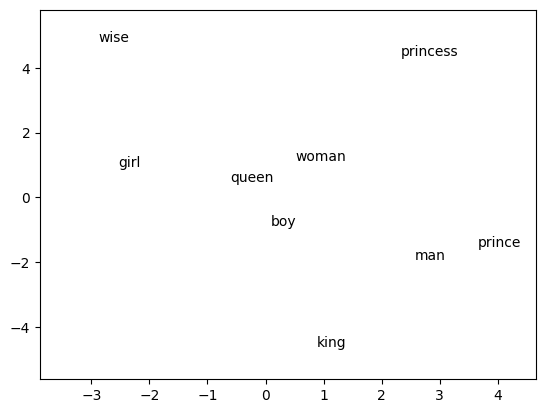

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1,x2 ))

PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING

plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (10,10)



plt.show()

Distance metrices

In [ ]:
from nltk.metrics import *
from sklearn.metrics.pairwise import euclidean_distances

#print("Euclidean Distnance: ",euclidean_distances(vector1.toarray()[0],vector1.toarray()[1]))



def find_nearest_word(word, word_vectors):
    # Find the index of the given word in the word vectors dataframe
    index = word_vectors.index[word_vectors['word'] == word].tolist()[0]

    # Get the vector representation of the given word
    target_vector = word_vectors.iloc[index, 1:].values.reshape(1, -1)

    # Calculate Euclidean distances between the target word vector and all other word vectors
    distances = euclidean_distances(word_vectors.iloc[:, 1:], target_vector)

    # Find the index of the word with the shortest distance (excluding the target word itself)
    nearest_index = distances.argpartition(1, axis=None)[1]

    # Get the nearest word
    nearest_word = word_vectors.iloc[nearest_index]['word']

    return nearest_word

# Example usage:
# Assuming w2v_df is your word vectors dataframe
nearest_words = {}
for word in w2v_df['word']:
    nearest_words[word] = find_nearest_word(word, w2v_df)

# Output the nearest word for all given words
for word, nearest_word in nearest_words.items():
    print(f"The nearest word to '{word}' is '{nearest_word}'.")



The nearest word to 'woman' is 'queen'.
The nearest word to 'boy' is 'queen'.
The nearest word to 'princess' is 'woman'.
The nearest word to 'man' is 'prince'.
The nearest word to 'girl' is 'queen'.
The nearest word to 'queen' is 'woman'.
The nearest word to 'king' is 'man'.
The nearest word to 'wise' is 'girl'.
The nearest word to 'prince' is 'man'.
